# Twitter Streaming with pySpark

In [2]:
import findspark
findspark.init('/home/sergio/spark-2.4.4-bin-hadoop2.7')

In [3]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [4]:
# Se crea una instancia de SparkContext, solo se debe correr una vez.
sc = SparkContext()

In [5]:
# Se inicia StreamingContext con batches en intervalos de 2 segundos
ssc = StreamingContext(sc, 2)
sqlContext = SQLContext(sc)

In [6]:
# Se abre un socket de streaming de texto para el mismo puerto que el twitter reader
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)

In [7]:
# Cantidad de lineas por ventana de stream (tamano del batch)
lines = socket_stream.window(60) 

In [8]:
# En esta tupla se guardan los nombres de los hashes

from collections import namedtuple

fields = ("hashtag", "count" )
Tweet = namedtuple( 'Tweet', fields )

## Aplicamos diferentes aplicaciones a los tweets para guardarlos en una tabla temporal
- Se crea una lista con todas las palabras
- Revisamos las palabras que empiezan con #
- Pasamos esas palabras a minusculas
- Se agregan las palabras repetidas
- Se guardan como objetos Tweet (tupla de hashtag + cantidad)
- Se ordenan de mayor a menor
- Se guardan en una tabla temporal en spark pero solo las top 10

In [9]:
( lines.flatMap( lambda text: text.split( " " ) )
  .filter( lambda word: word.lower().startswith("#") )
  .map( lambda word: ( word.lower(), 1 ) )
  .reduceByKey( lambda a, b: a + b ) 
  .map( lambda rec: Tweet( rec[0], rec[1] ) )
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
  .limit(10).registerTempTable("tweets") ) )

In [10]:
# Pasos para la visualizacion de los resultados

import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
%matplotlib inline 

In [11]:
# Aca se comienza el Streaming, para lo cual el twitter reader debe estar corriendo
ssc.start()

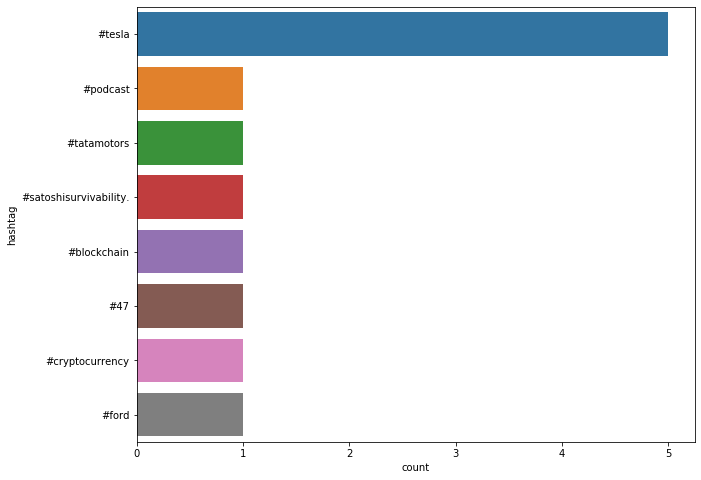

30


In [12]:
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
count = 0
while count < 30: # numero de veces que se debe actualizar el grafico
    
    time.sleep(2) # cada iteracion es cada 2 segundos
    top_10_tags = sqlContext.sql( 'Select hashtag, count from tweets' )
    top_10_df = top_10_tags.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="hashtag", data=top_10_df)
    plt.show()
    count = count + 1
    print(count) # el numero de iteracion por la que vamos

In [16]:
ssc.stop()